In [6]:
import pandas as pd
import numpy as np
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

In [7]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-306280812807


In [8]:
# NOTE: this step is not strictly required if you've already run the 01_... notebook
!rm -f /tmp/ml-100k.zip
!rm -rf /tmp/ml-100k
!wget -O /tmp/ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -j -o /tmp/ml-100k.zip -d /tmp/ml-100k

--2018-07-25 05:51:44--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘/tmp/ml-100k.zip’

/tmp/ml-100k.zip    100%[===================>]   4.70M  21.3MB/s    in 0.2s    

2018-07-25 05:51:45 (21.3 MB/s) - ‘/tmp/ml-100k.zip’ saved [4924029/4924029]

Archive:  /tmp/ml-100k.zip
  inflating: /tmp/ml-100k/allbut.pl  
  inflating: /tmp/ml-100k/mku.sh     
  inflating: /tmp/ml-100k/README     
  inflating: /tmp/ml-100k/u.data     
  inflating: /tmp/ml-100k/u.genre    
  inflating: /tmp/ml-100k/u.info     
  inflating: /tmp/ml-100k/u.item     
  inflating: /tmp/ml-100k/u.occupation  
  inflating: /tmp/ml-100k/u.user     
  inflating: /tmp/ml-100k/u1.base    
  inflating: /tmp/ml-100k/u1.test    
  inflating: /tmp/ml-100k/u2.bas

In [9]:
users = pd.read_csv("/tmp/ml-100k/u.user", sep='|', header=None, index_col=['userid'],
    names=['userid', 'age', 'gender', 'occupation', 'postal_code'])
users = users.drop('postal_code',1)
users.head()

,age,gender,occupation
userid,,,
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other


In [10]:
users_onehot=pd.get_dummies(users)
users_onehot.head()

,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
userid,,,,,,,,,,,,,,,,,,,,,
1,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,53,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,33,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
users_onehot_df = users_onehot.values.astype(np.float32) # built-in K-Means requires float32
print(users_onehot_df)

[[24.  0.  1. ...  0.  1.  0.]
 [53.  1.  0. ...  0.  0.  0.]
 [23.  0.  1. ...  0.  0.  1.]
 ...
 [20.  0.  1. ...  1.  0.  0.]
 [48.  1.  0. ...  0.  0.  0.]
 [22.  0.  1. ...  1.  0.  0.]]


In [12]:
from sagemaker import KMeans

data_location = 's3://{}/recommender_workshop/kmeans/data'.format(bucket)
output_location = 's3://{}/recommender_workshop/kmeans/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

#!aws s3 cp /tmp/ml-100k/u.user $data_location/u.user

k_value=5 #number of clusters
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.2xlarge',
                output_path=output_location,
                k=k_value,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-east-1-306280812807/recommender_workshop/kmeans/data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-306280812807/recommender_workshop/kmeans/output


In [13]:
%%time

kmeans.fit(kmeans.record_set(users_onehot_df))

INFO:sagemaker:Creating training-job with name: kmeans-2018-07-25-05-51-46-010


....................
Docker entrypoint called with argument(s): train
[07/25/2018 05:54:55 INFO 140209577031488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[07/25/2018 05:54:55 INFO 140209577031488] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'24', u'k': u'5', u'force_dense': u'True'}
[07/25/2018 05:54:55 INFO 140209577031488] Final configuration: {u'k': u'5', u'_

===== Job Complete =====
Billable seconds: 95
CPU times: user 376 ms, sys: 48 ms, total: 424 ms
Wall time: 3min 42s


In [14]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-07-25-05-55-28-450
INFO:sagemaker:Creating endpoint with name kmeans-2018-07-25-05-51-46-010


--------------------------------------------------------------!CPU times: user 252 ms, sys: 28 ms, total: 280 ms
Wall time: 5min 14s


In [15]:
pd.get_dummies(users.head())

,age,gender_F,gender_M,occupation_other,occupation_technician,occupation_writer
userid,,,,,,
1,24,0,1,0,1,0
2,53,1,0,1,0,0
3,23,0,1,0,0,1
4,24,0,1,0,1,0
5,33,1,0,1,0,0


In [16]:
result = kmeans_predictor.predict(users_onehot_df[0:5])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 3.0899548530578613
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.11634635925293
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 2.2019402980804443
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 3.0899548530578613
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
   

In [17]:
result = kmeans_predictor.predict(users_onehot_df)

cluster=[]
for i in range(k_value):
    cluster.append([r.label['distance_to_cluster'].float32_tensor.values[0] for r in result if r.label['closest_cluster'].float32_tensor.values[0] == i])

cluster_zip = sorted(zip())


[]

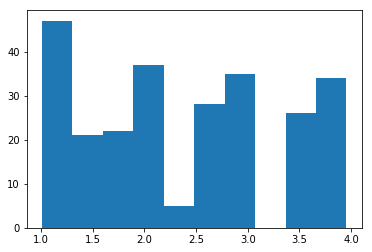

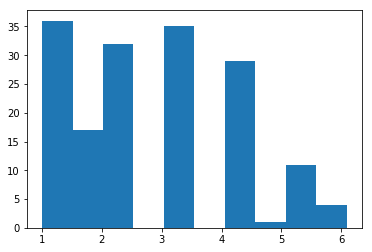

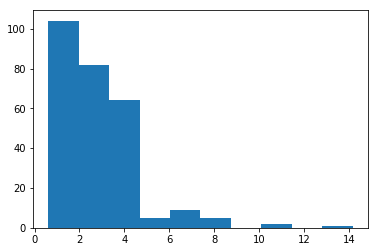

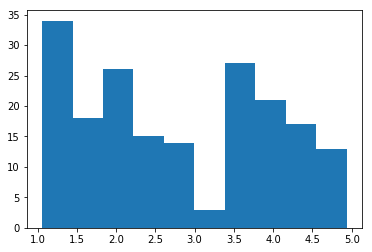

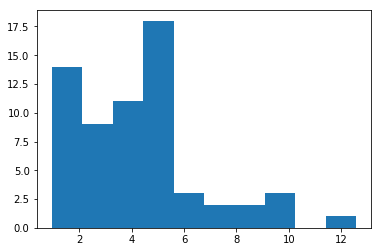

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(k_value):
    fig,ax = plt.subplots()
    ax.hist(cluster[i])

plt.plot()

In [19]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: kmeans-2018-07-25-05-51-46-010
